# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
os.chdir("/data2/mito_lineage/Analysis/multiplex")

In [2]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

### Remove this when running in snakemake

## 1.1 Parameters

In [3]:
# Parameters
INDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/"
#INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/"
N_DONORS=5
OUTDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/flt3"
sample_csv="/data2/mito_lineage/parameters/CHIP_april08_2021/CHIP_april08_2021.csv"

In [4]:
# INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
# OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
# N_DONORS=4 


## 1.2 Import packages

In [5]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
print(vireoSNP.__version__)
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo
%load_ext autoreload
%autoreload 2

0.4.2


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## 1.3 Load

In [7]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")
sample_labels = join(INDIR, "cell_labels.txt")

In [8]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
AD_shape = AD.todense().shape

In [9]:
# columns are 'ID', 'raw ID', and 'new index'. The first contains the
# suffix with the old id, the new index contains the mapping to the
# outputted subsampled cells, which is 1-based, and the raw ID is the initial cell IDs without the suffix.   
sample_labels = pd.read_csv(sample_labels)
sample_labels = sample_labels.sort_values('new index')
print('sample_labels', sample_labels.head())
print('AD_shape', AD_shape)
assert(AD_shape[1]) == sample_labels.shape[0] # These should match up.
    
#if sample_csv != "":
sample_df = pd.read_csv(sample_csv)
sample_df = sample_df[['out_name', 'sample_name']]
sample_df.columns = ["Name", "Sample"]
sample_names = sample_df["Sample"].to_dict() #{0: "Control", 1:"Flt3"}
# else:
#     ## THIS IS GLOBAL VARIABLE HOTFIX
#     sample_names = {0: "Control", 1:"Flt3"}

sample_labels                            ID              raw ID  new index
0  AAACGAATCTTACTCA-1_Control  AAACGAATCTTACTCA-1          1
1  AAACTCGAGTGGTGTG-1_Control  AAACTCGAGTGGTGTG-1          2
2  AAACTCGTCAATGCAC-1_Control  AAACTCGTCAATGCAC-1          3
3  AAACTGCTCTCGCGGA-1_Control  AAACTGCTCTCGCGGA-1          4
4  AAAGATGAGCGCATTT-1_Control  AAAGATGAGCGCATTT-1          5
AD_shape (19572, 6378)


## Add in cell IDs to get sample information

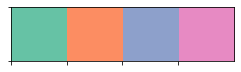

In [10]:
sns.palplot(sns.color_palette("Set2", 4))

In [11]:
# A. 
# Input: cell indices files, where first line is name of file, and the rest is a df with column header of 'old index', 'new index'
# Output: A. cell_map: Dictionary where each key is the sample file (relative), and the value is the 'new index' column. 
        # B. in_cell_names: List of the keys, which are files
in_cell_f = glob(cell_inds_names)
print('cell inds', in_cell_f)
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)

# Get the maximum index across the two
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))

# B. Input: in_cell_names: The list of keys
#    Output: cell_ind_map:  dict where keys are the sample map names and the values are unique ordered 0-indexed ints,
#                           with the order based on in_cell_names
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1



# cell_inds: np.array where the length is the number of cells in the pseudo population, 
#            and the element is an int that maps to a sample based on the cell_ind_map. 
cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]
cell_inds=cell_inds.astype(int)
# Assign colors to the samples.
sample_colors = pd.DataFrame([sample_names[x] for x in cell_inds], columns=["sample ID"])
colors = sns.color_palette("Set2", len(list(set(sample_colors['sample ID'])))) #{0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]
cell_colors = pd.Series(cell_colors, name="sample ID")

sample_colors

cell inds ['data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_0.txt', 'data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_1.txt', 'data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_2.txt']
data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_0.txt
data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_1.txt
data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/cell_indices_2.txt


,sample ID
0,Input
1,Input
2,Input
3,Input
4,Input
...,...
6373,Flt3l
6374,Flt3l
6375,Flt3l
6376,Flt3l


# 2 Run vireo to demultiplex

In [13]:
import pickle

In [14]:
modelCA=pickle.load(open(join(OUTDIR, f"donors.clones{N_DONORS}.modelCA.p"), 'rb'))
modelCA


In [15]:
doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)

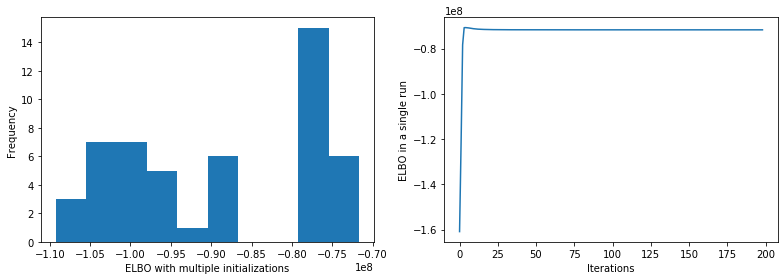

In [13]:
modelCA = run_vireo(AD, DP, N_DONORS, n_cores=32, plot_qc=True,out_f=join(OUTDIR, "donors"))
doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)

## Extract donors

In [16]:
cell_clusters = extract_clusters(modelCA, prob_thresh=0.9, doublet_thresh=0.9, doublet_prob=doublet_prob,
                                 sample_colors=sample_colors, outdir=OUTDIR, out_f="donors")
cell_clusters

{0: array([   4,    6,   12,   19,   36,   42,   46,   47,   50,   54,   55,
          58,   61,   69,   75,   76,   80,   84,   89,   92,   93,   98,
         101,  102,  104,  106,  110,  113,  114,  115,  120,  121,  122,
         123,  126,  141,  143,  146,  151,  161,  167,  168,  169,  180,
         185,  186,  192,  193,  194,  196,  201,  206,  209,  213,  215,
         224,  231,  232,  233,  237,  241,  242,  246,  249,  251,  256,
         257,  260,  261,  270,  271,  273,  275,  276,  281,  299,  301,
         302,  309,  313,  315,  321,  322,  331,  338,  342,  349,  354,
         355,  360,  372,  373,  375,  376,  377,  378,  383,  384,  389,
         393,  396,  398,  399,  404,  422,  425,  434,  435,  436,  438,
         439,  449,  451,  458,  459,  461,  466,  471,  473,  475,  479,
         486,  491,  498,  509,  510,  511,  521,  522,  525,  530,  538,
         547,  552,  553,  558,  571,  572,  576,  577,  580,  581,  583,
         584,  585,  590,  600,  60

In [16]:
run_elbo(AD, DP, out_f=join(OUTDIR, "donors_elbo"), 
         n_clone_list=np.arange(N_DONORS-2, N_DONORS+3), 
         n_cores=12, sample_colors=sample_colors, save_clusters=False,)

lineages 3
lineages 4
lineages 5
lineages 6
lineages 7


([], array([3, 4, 5, 6, 7]))

Clustering
Clustering


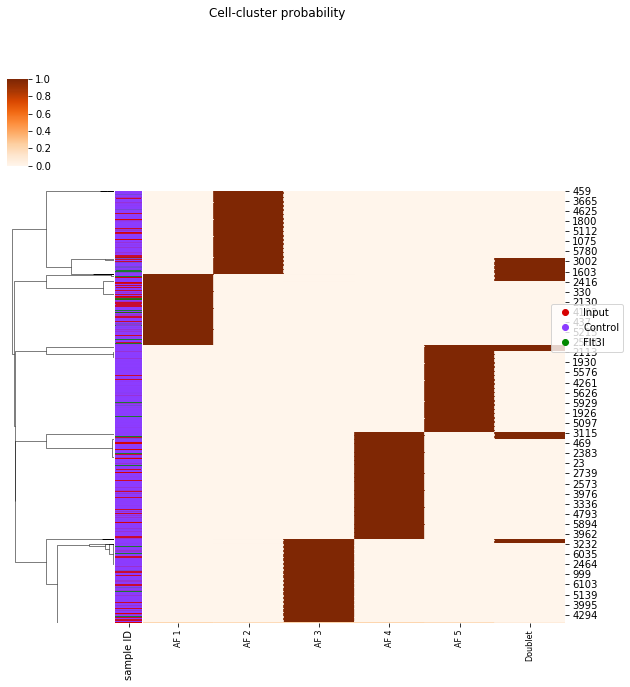

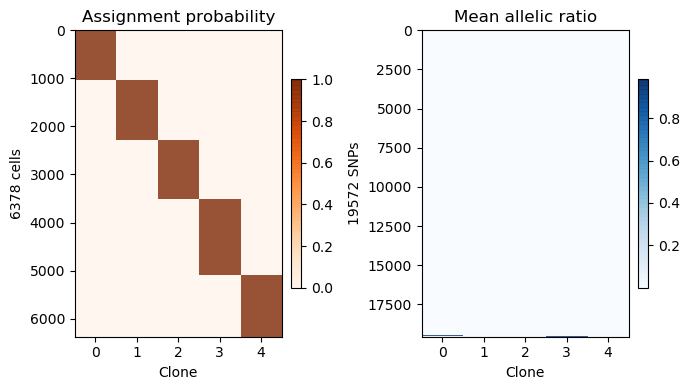

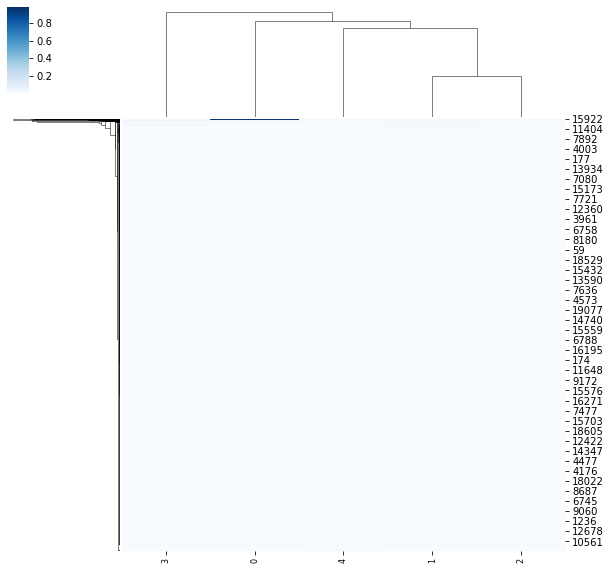

In [46]:
clust_df, AF_SNPs = plot_vireo_out(modelCA, out_f=join(OUTDIR, "multiplex_clusters_all"), labels=sample_colors,
                                   to_sqrt=False, doublet_prob=doublet_prob)

Control
              AF 1          AF 2          AF 3          AF 4          AF 5  \
843   1.000000e+00  4.544994e-07  3.584256e-07  4.800790e-07  4.259518e-07   
844   4.298186e-08  1.000000e+00  4.476849e-07  2.703275e-07  4.341294e-07   
845   1.482890e-08  1.169646e-07  1.000000e+00  3.861460e-08  4.194304e-08   
846   4.695836e-07  1.539491e-07  1.510497e-07  1.000000e+00  4.971917e-07   
847   1.000000e+00  3.163522e-07  2.886443e-07  6.999547e-08  3.994478e-07   
...            ...           ...           ...           ...           ...   
6151  1.086630e-08  1.000000e+00  1.971461e-07  4.104722e-07  6.109564e-08   
6152  1.000000e+00  1.782364e-07  2.988678e-07  2.306844e-07  4.816647e-07   
6153  3.936200e-07  2.268966e-07  2.027137e-07  4.654792e-07  1.000000e+00   
6154  4.957859e-09  2.104099e-08  4.356333e-07  4.332551e-07  1.000000e+00   
6155  1.000000e+00  4.662320e-07  4.917824e-07  3.984929e-07  5.931134e-08   

            Doublet  
843    0.000000e+00  
844    0.00

<Figure size 432x288 with 0 Axes>

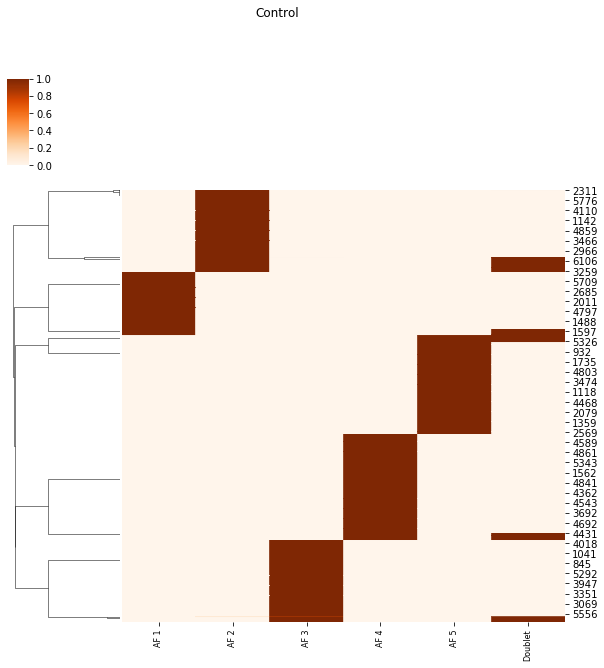

<Figure size 432x288 with 0 Axes>

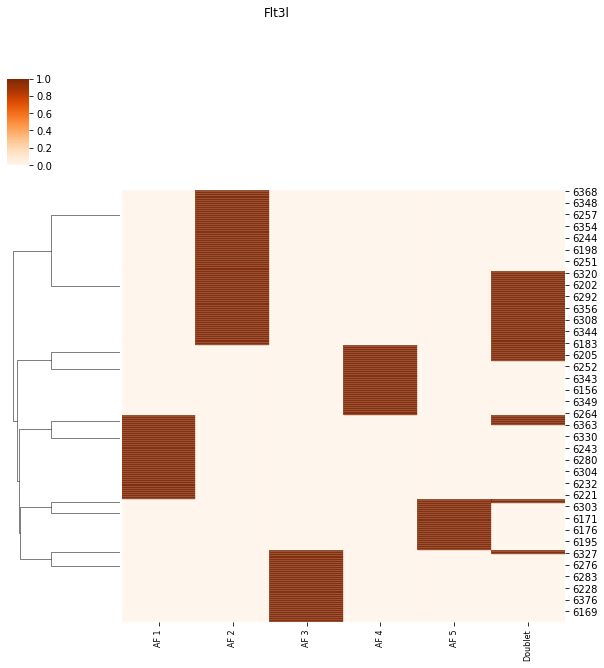

<Figure size 432x288 with 0 Axes>

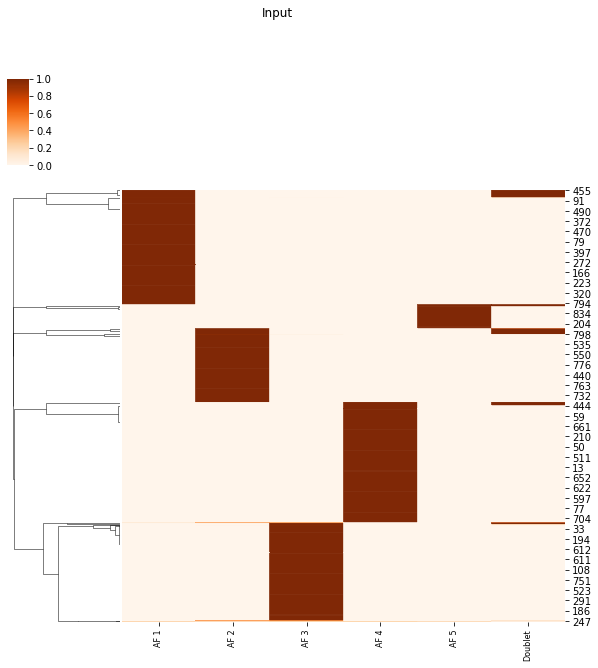

In [65]:
for ind, val in sample_colors.groupby("sample ID"):
    print(ind)
    print(clust_df.loc[val.index]) #, curr_AF_SNPs
    f = plt.figure()
#     curr_AF_SNPs = AF_SNPs 
#     im = heat_matrix(np.sqrt(curr_AF_SNPs[(curr_AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
#             display_value=False, row_sort=True)
    ch.plot_cluster(clust_df.loc[val.index], cmap='Oranges', alpha=0.8,
                to_row_clust=True, to_col_clust=False,
                to_legend=True,
                white_name=None)
    plt.suptitle(ind)
    plt.savefig(join(OUTDIR, f"multiplex_clusters_{ind}"))

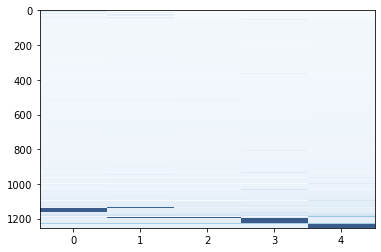

In [66]:
f = plt.figure()
im = heat_matrix(np.sqrt(AF_SNPs[(AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.savefig(join(OUTDIR, "multiplex_AF_SNPs_all_afFilt"))

## Separate for each sample before